In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import mne
import moabb
import ordpy
from ordpy import maximum_complexity_entropy, minimum_complexity_entropy
from moabb.datasets import BNCI2014_001
from moabb.paradigms import MotorImagery
from mne_connectivity import spectral_connectivity_epochs
import matplotlib.pyplot as plt
from nilearn import plotting
from matplotlib import colormaps
from tqdm import tqdm

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/home/hice1/mchen439/scratch/miniconda3/envs/MATH8803/lib/python3.11/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


In [2]:
def symmetrize(A):
	return A + A.T - np.diag(np.diag(A))

In [3]:
# From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8865144/ Table 2 Cortex Means
ch_names = [
    "Fz", "FC3", "FC1", "FCz", "FC2", "FC4", "C5", "C3", "C1", "Cz", "C2",
        "C4", "C6", "CP3", "CP1", "CPz", "CP2", "CP4", "P1", "Pz", "P2", "POz",
        "EOG1", "EOG2", "EOG3"
]

EEG_Locations = {
	"Fz": [0.88, 34.43, 62.21],
	"FC3": [-46.09, 7.35, 56.46],
	"FC1": [-24.69, 5.73, 71.11],
	"FCz": [0.41, 6.77, 75.19],
	"FC2": [24.09, 5.4, 72.18],
	"FC4": [47.52, 6.49, 58.34],
	"C5": [-66.15, -20.58, 33.83],
	"C3": [-50.88, -21.18, 59.95],
	"C1": [-25.56, -23.82, 75.26],
	"Cz": [-0.47, -24.64, 80.16],
	"C2": [23.84, -24.31, 78.00],
	"C4": [50.78, -23.18, 63.58],
	"C6": [66.48, -21.77, 36.16],
	"CP3": [-49.15, -47.78, 58.42],
	"CP1": [-25.64, -48.14, 71.46],
	"CPz": [-0.73, -50.47, 75.85],
	"CP2": [24.46, -49.71, 75.38],
	"CP4": [46.66, -48.71, 62.98],
	"P1":  [-25.9, -68.45, 61.21],
	"Pz": [-1.94, -69.12, 66.04],
	"P2": [20.8, -69.28, 64.82],
	"POz": [-2.76, -90.20, 42.12]
}

In [4]:
paradigm = MotorImagery(n_classes=4)
mne.set_config("MNE_DATA", "/home/hice1/mchen439/scratch/mne_data")
mne.set_config("MNE_DATASETS_BNCI_PATH", "/home/hice1/mchen439/scratch/mne_data")
print(mne.get_config())

Choosing from all possible events


{'MNE_DATA': '/home/hice1/mchen439/scratch/mne_data', 'MNE_DATASETS_ALEXEEG_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_BNCI_PATH': '/home/hice1/mchen439/scratch/mne_data', 'MNE_DATASETS_EEGBCI_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_FAKEDATASET-IMAGERY-10-2--60-60--120-120--FAKE1-FAKE2-FAKE3--C3-CZ-C4_PATH': '/tmp/tmpwour6ucf', 'MNE_DATASETS_FAKEVIRTUALREALITYDATASET-P300-21-1--60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60--120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120--TARGET-NONTARGET--C3-CZ-C4_PATH': '/tmp/tmpvhx98uwa', 'MNE_DATASETS_GIGADB_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_LEE2019-MI_PATH': '/home/hice1/mchen439/mne

/tmp/ipykernel_49157/3997935127.py:3: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  mne.set_config("MNE_DATASETS_BNCI_PATH", "/home/hice1/mchen439/scratch/mne_data")


In [5]:
datasetMotorImagery = BNCI2014_001()
subjects = [1]

X, y, metadata = paradigm.get_data(dataset=datasetMotorImagery, subjects=subjects)
print(metadata.columns)
print(np.unique(y))

/home/hice1/mchen439/scratch/miniconda3/envs/MATH8803/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:310: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return func(X, **(kw_args if kw_args else {}))
/home/hice1/mchen439/scratch/miniconda3/envs/MATH8803/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:310: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return func(X, **(kw_args if kw_args else {}))
/home/hice1/mchen439/scratch/miniconda3/envs/MATH8803/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:310: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return func(X, **(kw_args if kw_args else {}))
/home/hice1/mchen439/scratch/minicond

Index(['subject', 'session', 'run'], dtype='object')
['feet' 'left_hand' 'right_hand' 'tongue']


In [6]:
print(X.shape, y.shape, type(X), type(y), print(metadata.shape), print(type(metadata)))

(576, 3)
<class 'pandas.core.frame.DataFrame'>
(576, 22, 1001) (576,) <class 'numpy.ndarray'> <class 'numpy.ndarray'> None None


In [7]:
y_encoded = np.zeros(y.shape)
for idx in range(y.shape[0]):
	if y[idx] == "tongue":
		y_encoded[idx] = 0
	elif y[idx] == "right_hand":
		y_encoded[idx] = 1
	elif y[idx] == "left_hand":
		y_encoded[idx] = 2
	else:
		y_encoded[idx] = 3

In [10]:
def generate_fisher_information_entropy_values_whole_brain(X, y_encoded, index_start, index_end):
	assert X.shape[0] == y_encoded.shape[0]
	entropy_fi = np.zeros((X.shape[0], 3)) # entropy, complexity, and label for trial
	for i in tqdm(range(X.shape[0])):
		entropy, fi = ordpy.fisher_shannon(data=X[i, :,index_start:index_end], dx=int(5), dy=int(1), taux=int(3), tauy=int(1))
		entropy_fi[i][0] = entropy
		entropy_fi[i][1] = fi
		entropy_fi[i][2] = y_encoded[i]
	return entropy_fi

100%|██████████| 576/576 [01:03<00:00,  9.11it/s]


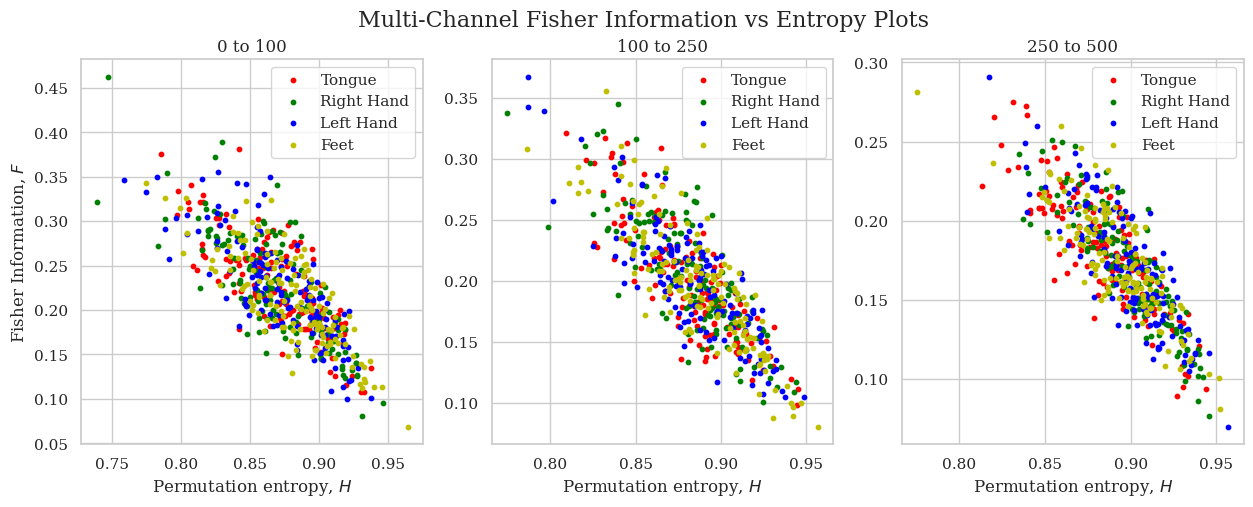

In [12]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].set_ylabel('Fisher Information, $F$')
f.suptitle('Multi-Channel Fisher Information vs Entropy Plots', fontsize=16)
for idx, (start_idx, end_idx) in enumerate([(0, 100), (100, 250), (250, 500)]):
	result_all_trials = generate_fisher_information_entropy_values_whole_brain(X, y_encoded, start_idx, end_idx)
	tongue = result_all_trials[result_all_trials[:, 2] == 0]
	right_hand = result_all_trials[result_all_trials[:, 2] == 1]
	left_hand = result_all_trials[result_all_trials[:, 2] == 2]
	feet = result_all_trials[result_all_trials[:, 2] == 3]
	#upper = ax[idx].plot(hmin, cmin, linewidth=1.5, color='#202020', zorder=0)
	#lower = ax[idx].plot(hmax, cmax, linewidth=1.5, color='#202020', zorder=0)
	tongue_points = ax[idx].scatter(x=tongue[:,0], y=tongue[:,1], c="r", s=10)
	right_hand_points = ax[idx].scatter(x=right_hand[:,0], y=right_hand[:,1], c="g", s=10)
	left_hand_points = ax[idx].scatter(x=left_hand[:,0], y=left_hand[:,1], c="b", s=10)
	feet_points = ax[idx].scatter(x=feet[:,0], y=feet[:,1], c="y", s=10)
	ax[idx].set_xlabel('Permutation entropy, $H$')
	#ax[0, idx].set_ylabel('Statistical complexity, $C$')
	ax[idx].set_title(f'{start_idx} to {end_idx}')
	ax[idx].grid(visible=True)
	ax[idx].legend((tongue_points, right_hand_points, left_hand_points, feet_points), ("Tongue", "Right Hand", "Left Hand", "Feet"), scatterpoints=1)
plt.show()